In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from dataprocessor import *

/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/feifang/miniconda3/envs/sno

## Load test set

In [3]:
processor = ImdbProcessor('../imdb-data')
test_examples = processor.get_test_examples()

In [4]:
labels_test_str = [example.label for example in test_examples]
labels_test = [1 if l == 'pos' else 0 for l in labels_test_str]

In [47]:
def read_txt(input_file):
    return np.loadtxt(input_file)

In [48]:
def get_probs(train_set):
    pred_file = '../lstm_output/{}.txt'.format(train_set)
    pred_probs = read_txt(pred_file)
    return pred_probs

In [49]:
def get_preds(probs):
    return (probs > 0.5).astype(int)

In [50]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_accuracy(preds):
    return accuracy_score(labels_test, preds)

def get_auc(probs):
    return roc_auc_score(labels_test, probs)

## Load predictions

In [59]:
models = ['sd800', 'wd04', 'og', 'sd1600', 'sd3200', 'sd6400', 'sd12800', 'nwd00']

In [60]:
probs_dict = {}
preds_dict = {}
for train_set in models:
    probs_dict[train_set] = get_probs(train_set)
    preds_dict[train_set] = get_preds(probs_dict[train_set])

## AUC

#### Snorkel model (no deep learning)'s AUC on test set: 0.876

In [62]:
auc_dict = {}
for train_set in sorted(probs_dict.keys()):
    auc_score = get_auc(probs_dict[train_set])
    auc_dict[train_set] = auc_score
    print("AUC on {}: {}".format(train_set, auc_score))

AUC on nwd00: 0.7816846253671197
AUC on og: 0.9388325865719553
AUC on sd12800: 0.9106639710402294
AUC on sd1600: 0.8182989037634042
AUC on sd3200: 0.8668804624001092
AUC on sd6400: 0.8857327231746465
AUC on sd800: 0.7997171026569223
AUC on wd04: 0.9032172460897481


# Plot

In [69]:
ds_map = {i: 'sd' + str(i) for i in [800, 1600, 3200, 6400, 12800]}

In [70]:
ds_map[25000] = 'og'

In [71]:
import matplotlib.pyplot as plt

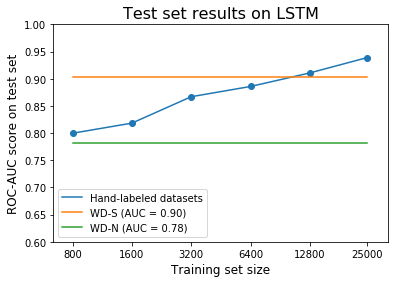

In [130]:
xs = [ds_size / 800 for ds_size in list(ds_map.keys())]
aucs = [auc_dict[ds_map[ds * 800]] for ds in xs]
plt.xscale("log", basex=2)
plt.ylim(0.6,1.)
plt.xlim(0.8, 40)
plt.xticks(xs, list(ds_map.keys()))
plt.scatter(xs, aucs)
plt.plot(xs, aucs, label='Hand-labeled datasets')
plt.xlabel("Training set size", fontsize=12)
plt.ylabel("ROC-AUC score on test set", fontsize=12)
plt.plot(np.linspace(1, 25000/800, 30), [auc_dict['wd04']] * 30, label="WD-S (AUC = 0.90)")
plt.plot(np.linspace(1, 25000/800, 30), [auc_dict['nwd00']] * 30, label="WD-N (AUC = 0.78)")
plt.title("Test set results on LSTM", fontsize=16)
plt.legend()

## Calculating NWD00's AUC

In [108]:
# load data into pandas
def read_data(dir_path):
    examples = []
    for filename in os.listdir(dir_path):
        if not filename.endswith("txt"):
            continue
        keys = filename.split(".")[0].split("_")
        assert len(keys) == 3
        # keys is [id, label, review_score]. For now we are only interested in the label
        label = keys[1]
        with open(os.path.join(dir_path, filename)) as f:
            text = f.read().strip().replace("<br />", " ")
        examples.append([text, 1 if label == 'pos' else 0])
    return examples

In [110]:
NWD_DIR = '../imdb-data/nwd00'
nwd_data = read_data(NWD_DIR)
nwd_df = pd.DataFrame(nwd_data, columns=['text', 'weak_label'])
nwd_df

,text,weak_label
0,7 if you're a kid- 6 if you claim to be an adu...,1
1,i must say this movie is truly amazing and hea...,0
2,"I'm glad some people liked this, but I hated t...",0
3,"""Burning Paradise"" is a combination of neo-Sha...",0
4,"I wasn't expecting much, and, to be honest, I ...",1
...,...,...
20636,"Probably the two main significances of ""Elmer'...",1
20637,This little show is obviously some stupid litt...,0
20638,dark angel rocks! the best show i have seen in...,1
20639,Your average garden variety psychotic nutcase ...,0


In [111]:
TRAIN_DIR = '../imdb-data/og'
train_data = read_data(TRAIN_DIR)
train_df = pd.DataFrame(train_data, columns=['text', 'label'])

In [112]:
train_df

,text,label
0,I have to start saying it has been a long time...,1
1,I thought that Mukhsin has been wonderfully wr...,1
2,First of all this was not a three hour movie -...,1
3,I cant understand at all why so many Godzilla ...,0
4,It's beyond my comprehension that so much rubb...,1
...,...,...
24995,This movie is about this wimpy guy who decides...,1
24996,**Warning! Spoilers Ahead!** This short is pa...,1
24997,I really enjoyed The 60's. Not being of that g...,1
24998,"While on a vacation at the beach, red-haired b...",0


In [122]:
df = nwd_df.merge(train_df, 'outer').drop_duplicates()

In [124]:
df = df.dropna()

In [125]:
df

,text,weak_label,label
0,7 if you're a kid- 6 if you claim to be an adu...,1.0,1
1,i must say this movie is truly amazing and hea...,0.0,1
2,"I'm glad some people liked this, but I hated t...",0.0,0
3,"""Burning Paradise"" is a combination of neo-Sha...",0.0,1
4,"I wasn't expecting much, and, to be honest, I ...",1.0,1
...,...,...,...
20790,"Probably the two main significances of ""Elmer'...",1.0,1
20791,This little show is obviously some stupid litt...,0.0,0
20792,dark angel rocks! the best show i have seen in...,1.0,1
20793,Your average garden variety psychotic nutcase ...,0.0,1


In [126]:
from sklearn.metrics import roc_auc_score

In [127]:
roc_auc_score(list(df['label']), list(df['weak_label']))

0.743981674755479

In [128]:
auc_dict

{'nwd00': 0.7816846253671197,
 'og': 0.9388325865719553,
 'sd12800': 0.9106639710402294,
 'sd1600': 0.8182989037634042,
 'sd3200': 0.8668804624001092,
 'sd6400': 0.8857327231746465,
 'sd800': 0.7997171026569223,
 'wd04': 0.9032172460897481}